# Training and validation on the Boston Housing dataset (Regression)

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))
from layers import FullyConnected, ReLU, Dropout
from losses import MSELoss
from optimizers import Adam
from network import NeuralNetwork
from trainer import Trainer
from utils import train_val_test_split, standard_scale

np.random.seed(0)

## Load and preprocess the Boston Housing dataset

### Download the data from the internet

In [2]:
import urllib.request
import numpy as np

# Download Boston Housing data from UCI
boston_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
boston_path = "../data/housing.data"
if not os.path.exists(boston_path):
    os.makedirs(os.path.dirname(boston_path), exist_ok=True)
    urllib.request.urlretrieve(boston_url, boston_path)

# Load the data
data = []
with open(boston_path, "r") as f:
    for line in f:
        if not line.strip():
            continue
        values = line.strip().split()
        if len(values) >= 14:
            data.append([float(x) for x in values])

data = np.array(data)
X = data[:, :-1]  # Features (13 features)
y = data[:, -1:]  # Target (house prices)

print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")

Dataset shape: (506, 13), Target shape: (506, 1)
Features: 13, Samples: 506


### Preprocess the data

In [3]:
# Scale features and target properly
X_scaled, X_mean, X_std = standard_scale(X)
y_scaled, y_mean, y_std = standard_scale(y)

# Split into train/val/test
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(
    X_scaled, y_scaled, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (354, 13), Val: (75, 13), Test: (77, 13)


## Build the network

In [4]:
layers = [
    FullyConnected(13, 64),
    ReLU(),
    FullyConnected(64, 32),
    ReLU(),
    FullyConnected(32, 1)
]

net = NeuralNetwork(layers)
lr = 0.001 
optimizer = Adam(lr=lr, weight_decay=0.001) 
loss_fn = MSELoss()
trainer = Trainer(net, optimizer, loss_fn)

## Train the network

In [5]:
train_losses, val_losses = trainer.train(X_train, y_train, X_val, y_val, epochs=300, batch_size=16, patience=20)

Epoch 1: train loss=0.5873, val loss=0.3611
Epoch 2: train loss=0.3583, val loss=0.2565
Epoch 3: train loss=0.2264, val loss=0.2353
Epoch 4: train loss=0.1977, val loss=0.2026
Epoch 5: train loss=0.1744, val loss=0.1930
Epoch 6: train loss=0.1651, val loss=0.1790
Epoch 7: train loss=0.1622, val loss=0.1852
Epoch 8: train loss=0.1654, val loss=0.1677
Epoch 9: train loss=0.1575, val loss=0.1742
Epoch 10: train loss=0.1940, val loss=0.1749
Epoch 11: train loss=0.1914, val loss=0.2044
Epoch 12: train loss=0.1539, val loss=0.1747
Epoch 13: train loss=0.1553, val loss=0.1652
Epoch 14: train loss=0.1425, val loss=0.1591
Epoch 15: train loss=0.1380, val loss=0.1531
Epoch 16: train loss=0.1332, val loss=0.1506
Epoch 17: train loss=0.1369, val loss=0.1490
Epoch 18: train loss=0.1359, val loss=0.1464
Epoch 19: train loss=0.1291, val loss=0.1531
Epoch 20: train loss=0.1245, val loss=0.1471
Epoch 21: train loss=0.1240, val loss=0.1488
Epoch 22: train loss=0.1392, val loss=0.1555
Epoch 23: train los

## Visualize training and validation losses

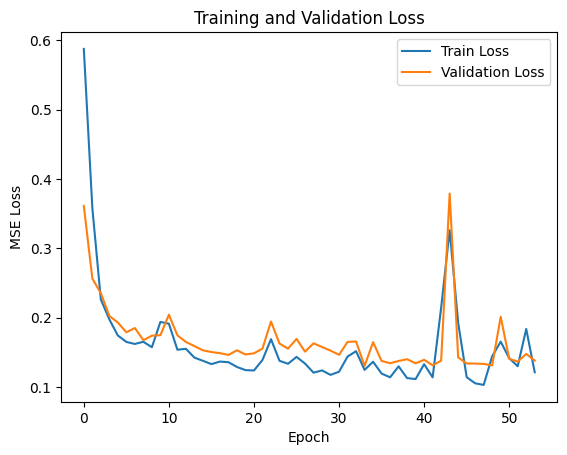

In [6]:
if train_losses is not None:
    plt.plot(train_losses, label='Train Loss')
if val_losses is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluate on test set

In [7]:
# Make predictions and denormalize back to original scale
y_pred_scaled = net.forward(X_test)

# Denormalize predictions and targets back to original scale
y_pred = y_pred_scaled * y_std + y_mean
y_test_original = y_test * y_std + y_mean

# Calculate metrics in original scale
mse = np.mean((y_test_original - y_pred) ** 2)
mae = np.mean(np.abs(y_test_original - y_pred))
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')

# Calculate R² score in original scale
ss_res = np.sum((y_test_original - y_pred) ** 2)
ss_tot = np.sum((y_test_original - np.mean(y_test_original)) ** 2)
r2 = 1 - (ss_res / ss_tot)
print(f'Test R² Score: {r2:.4f}')

Test MSE: 15.8785
Test MAE: 2.6483
Test R² Score: 0.7707
